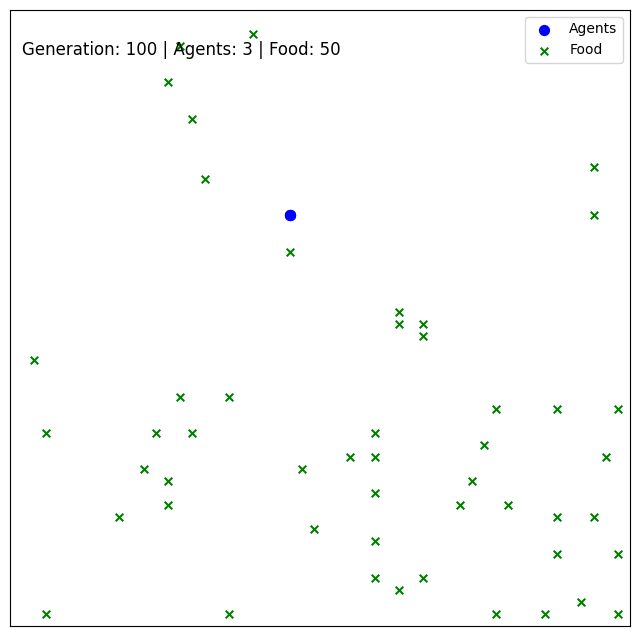

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.spatial import KDTree

# Simulation parameters
GRID_SIZE = 50  # Size of the grid (50x50)
INITIAL_NUM_AGENTS = 100  # Initial number of agents
INITIAL_NUM_FOOD = 50  # Initial number of food units
NUM_GENERATIONS = 100  # Total number of generations
INTERVAL = 200  # Interval between frames in milliseconds
VISION_RADIUS = 10  # Vision radius for agents

# Probabilities
REPRODUCTION_PROB = 1.0  # Probability of reproducing after eating food
STARVATION_PROB = 0.24  # Probability of dying if no food is eaten
FOOD_SPAWN_PROB = 0.05  # Probability of new food spawning at a random location each generation


# Agent class with optimized state representation
class Agent:
    __slots__ = ['x', 'y']

    def __init__(self, x, y):
        self.x = x  # X-coordinate
        self.y = y  # Y-coordinate

    def move_towards(self, target_x, target_y):
        """Move the agent one step towards the target coordinates."""
        if self.x < target_x:
            self.x += 1
        elif self.x > target_x:
            self.x -= 1
        if self.y < target_y:
            self.y += 1
        elif self.y > target_y:
            self.y -= 1
        # If already at the target, stay


# Initialize agents and food using NumPy for efficiency
agents = [Agent(x, y) for x, y in
          zip(np.random.randint(0, GRID_SIZE, INITIAL_NUM_AGENTS),
              np.random.randint(0, GRID_SIZE, INITIAL_NUM_AGENTS))]
food = set(zip(np.random.randint(0, GRID_SIZE, INITIAL_NUM_FOOD),
               np.random.randint(0, GRID_SIZE, INITIAL_NUM_FOOD)))

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, GRID_SIZE)
ax.set_ylim(-1, GRID_SIZE)
ax.set_xticks([])
ax.set_yticks([])

# Scatter plots for agents and food
scatter_agents = ax.scatter([], [], s=50, c='blue', label='Agents')  # Agents
scatter_food = ax.scatter([], [], s=30, c='green', marker='x', label='Food')  # Food
generation_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                          verticalalignment='top')
ax.legend(loc='upper right')


def init():
    """Initialize the scatter plots."""
    scatter_agents.set_offsets(np.empty((0, 2)))  # Corrected to a 2D empty array
    scatter_food.set_offsets(np.empty((0, 2)))  # Corrected to a 2D empty array
    generation_text.set_text('')
    return scatter_agents, scatter_food, generation_text


def find_nearest_food(agent, kd_tree, food_positions):
    """
    Find the nearest food item to the agent within the vision radius.

    Parameters:
    - agent: The agent object.
    - kd_tree: KDTree object containing food positions.
    - food_positions: NumPy array of food coordinates.

    Returns:
    - Tuple of (food_x, food_y) if found, else None.
    """
    if food_positions.size == 0:
        return None
    # Query KDTree for all food within VISION_RADIUS
    indices = kd_tree.query_ball_point([agent.x, agent.y], VISION_RADIUS)
    if not indices:
        return None
    # Find the nearest food among the visible ones
    visible_food = food_positions[indices]
    distances = np.linalg.norm(visible_food - np.array([agent.x, agent.y]), axis=1)
    nearest_index = np.argmin(distances)
    return tuple(visible_food[nearest_index])


def update(frame):
    """Update the positions of agents and food for each frame."""
    global agents, food

    new_agents = []
    eaten_food = set()

    # Build KDTree for current food positions
    food_positions = np.array(list(food))
    if food_positions.size > 0:
        kd_tree = KDTree(food_positions)
    else:
        kd_tree = None

    # Move agents towards nearest visible food
    for agent in agents:
        if kd_tree is not None:
            target = find_nearest_food(agent, kd_tree, food_positions)
        else:
            target = None

        if target:
            agent.move_towards(*target)
            # Check if agent has reached the food
            if (agent.x, agent.y) in food:
                eaten_food.add((agent.x, agent.y))
                # Reproduction
                if random.random() < REPRODUCTION_PROB:
                    new_agents.append(Agent(agent.x, agent.y))
        else:
            # No food within vision; agent can perform random movement or stay
            # Here, we'll keep the agent stationary
            pass

    # Remove eaten food
    food -= eaten_food

    # Add new agents from reproduction
    agents.extend(new_agents)

    # Starvation: Remove agents that didn't eat
    surviving_agents = []
    for agent in agents:
        if (agent.x, agent.y) in eaten_food:
            # Agent ate; guaranteed survival
            surviving_agents.append(agent)
        else:
            # Agent did not eat; may starve
            if random.random() > STARVATION_PROB:
                surviving_agents.append(agent)
    agents = surviving_agents

    # Spawn new food with a certain probability
    if random.random() < FOOD_SPAWN_PROB:
        new_food = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
        food.add(new_food)

    # Maintain food count
    while len(food) < INITIAL_NUM_FOOD:
        new_food = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
        food.add(new_food)

    # Update scatter plot data
    if agents:
        agent_positions = np.array([(agent.x, agent.y) for agent in agents])
        scatter_agents.set_offsets(agent_positions)
    else:
        scatter_agents.set_offsets(np.empty((0, 2)))  # No agents left

    if food:
        food_positions = np.array(list(food))
        scatter_food.set_offsets(food_positions)
    else:
        scatter_food.set_offsets(np.empty((0, 2)))  # No food left

    # Update generation text
    generation_text.set_text(f'Generation: {frame + 1} | Agents: {len(agents)} | Food: {len(food)}')

    # Terminate animation early if no agents remain
    if not agents:
        ani.event_source.stop()

    return scatter_agents, scatter_food, generation_text


# Create the animation
ani = FuncAnimation(fig, update, init_func=init, frames=NUM_GENERATIONS,
                    interval=INTERVAL, blit=True, repeat=False)

# Embed the animation into the notebook without displaying the last frame as a static image
HTML(ani.to_jshtml())